In [1]:
print('hello')

hello


In [5]:
%pip install nltk
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 91.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# worldcloud
import random
from wordcloud import WordCloud


In [7]:
# Download NLTK resources (only needed once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enzoberreur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/enzoberreur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/enzoberreur/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
# retrieving the datasets we used for the last notebook

raw_path = 'data/olist_datasets/'

df_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
df_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
df_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')


# I - Sentiment analysis of customer reviews

## A - Reminders on the Review dataframe

In [9]:
# checking that df_order_reviews is loaded

df_order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


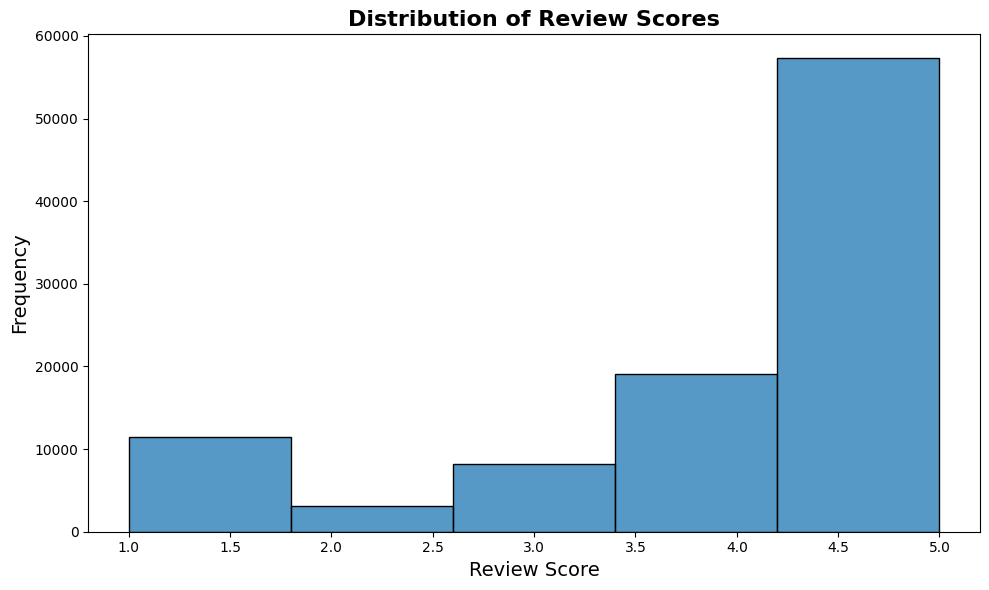

In [10]:
# Create a distribution plot (dist plot) with seaborn on the review score

# "professional" colors
colors = ['#2C3E50', '#E74C3C', '#ECF0F1', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram with seaborn
ax = sns.histplot(data=df_order_reviews, 
            x='review_score',
            bins=5,
            edgecolor='black',
            stat='count')

# Customizing the plot
plt.title('Distribution of Review Scores', fontsize=16, fontweight='bold')
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Ajuster les marges
plt.tight_layout()

# Show the plot
plt.show();


In [11]:
# Check for missing values in review comments
print(f"Missing review comments: {df_order_reviews['review_comment_message'].isnull().sum()} out of {len(df_order_reviews)} ({df_order_reviews['review_comment_message'].isnull().sum()/len(df_order_reviews):.2%})")

# Filter out rows with missing comments
reviews_with_comments = df_order_reviews.dropna(subset=['review_comment_message'])
print(f"Number of reviews with comments: {len(reviews_with_comments)}")



Missing review comments: 58247 out of 99224 (58.70%)
Number of reviews with comments: 40977


In [12]:
# Create a new column to categorize reviews as positive, neutral, or negative
def categorize_sentiment(score):
    '''if score is >=4 then good, if <3 then bad, else neutral'''
    if score >= 4:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'
    
df_order_reviews['sentiment_category'] = df_order_reviews['review_score'].apply(categorize_sentiment)


/var/folders/c8/v190j9n90gg6d6bhd7xsmm2r0000gn/T/ipykernel_29427/3012708.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=[colors[1], colors[5], colors[4]])


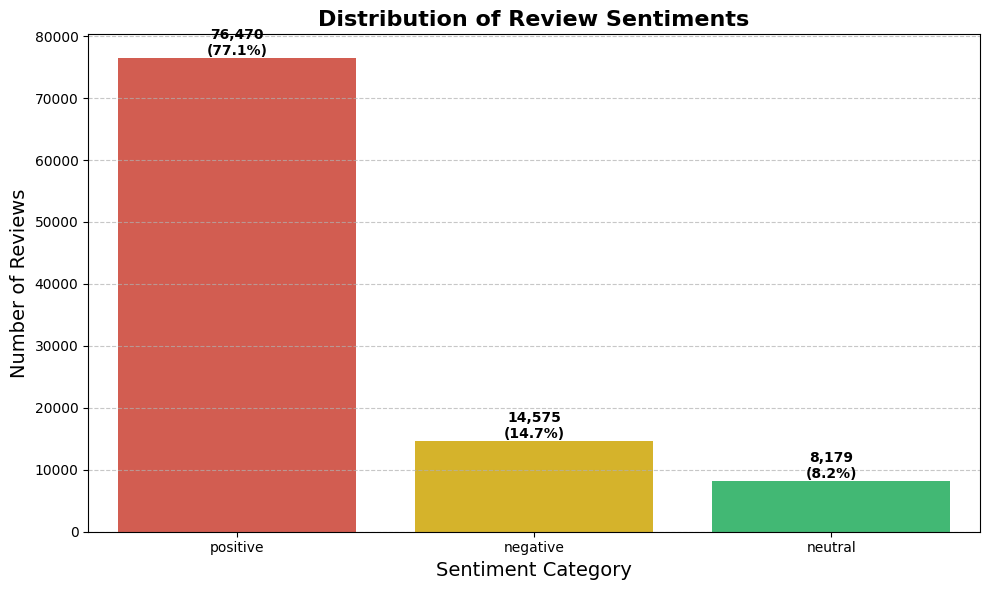

In [13]:
# Visualize the sentiment distribution - how many reviews by categories?

sentiment_counts = df_order_reviews['sentiment_category'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=[colors[1], colors[5], colors[4]])

for i, count in enumerate(sentiment_counts):
    percentage = count / len(df_order_reviews) * 100
    ax.text(i, count + 500, f"{count:,}\n({percentage:.1f}%)", ha='center', fontweight='bold')

# Customize the plot
plt.title('Distribution of Review Sentiments', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


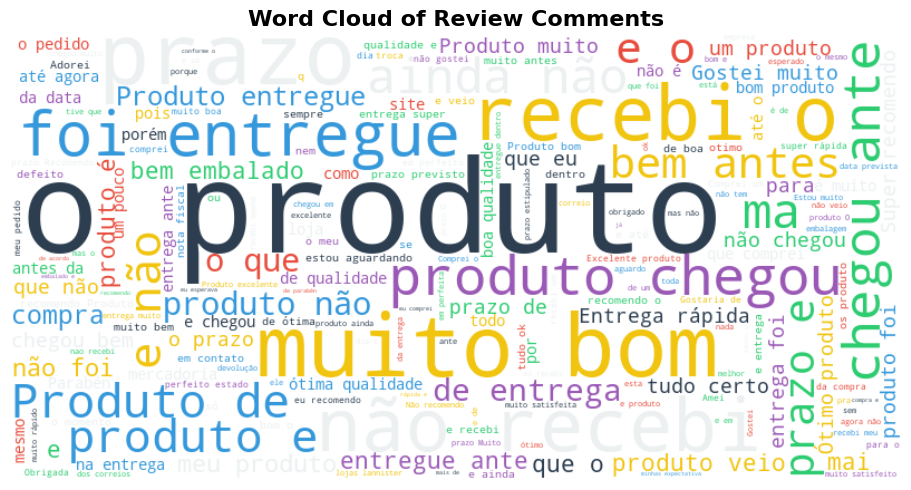

In [14]:
## Wordcloud

# Create a wordcloud on orders with negative reviews only

# Define a color function
def color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    return random.choice(colors)

# Example: Word cloud from review comments
plt.figure(figsize=(10, 5))

# every order
#wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(' '.join(df_order_reviews['review_comment_message'].dropna()))

# only negative reviews
reviews_with_negative_comments = reviews_with_comments[reviews_with_comments.review_score < 3]
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func)
wordcloud.generate(' '.join(reviews_with_comments['review_comment_message'].dropna()))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Review Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


## B - Text Preprocessing and conversion to numerical features

### 1 - Cleaning a small sample of the data and looking at the results

In [15]:
# create a new sample dataframe, that will be a sample of df_order_reviews
# which only have non null review_comment_messages
# which only contains review_id, review_score, review_comment_message

sample_df = df_order_reviews.dropna(subset=['review_comment_message']).sample(1000, random_state=42)
sample_df = sample_df[['review_id', 'review_score', 'review_comment_message']]
sample_df.head()


,review_id,review_score,review_comment_message
37062,d3c62500417e7eeab7c6ac2151b67357,4,Um produto como uma carteira somente poderia s...
17697,0f952ad4dfb88a77f12211a4038c70dd,5,"Entrega no prazo , bom produto ."
41606,067b7c9c760d8bda7a2c38fb1f3fdf6e,5,entrega rápida
41683,62f78be17aa2ef7db33e5781e00e7dc8,5,Chegou no prazo e atendeu as minhas espectativas
75879,9fcdf7983153b632cdbab78bf7d7f83a,5,Logística ótima entregue antes do prazo previs...


In [16]:
# create a new comment_clean column which makes the text LOWER (no uppercases)
sample_df['comment_clean'] = sample_df['review_comment_message'].str.lower()


In [17]:
# remove the special characters using a simple regex function

sample_df['comment_clean'] = sample_df['comment_clean'].str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)


In [18]:
# tokenize the text - meaning, isolate all words into a list, using the NLTK library, and another column - comment_clean_tokenized

sample_df['comment_clean_tokenized'] = sample_df['comment_clean'].apply(lambda x: nltk.word_tokenize(x) if isinstance(x, str) else [])


In [19]:
# then remove the stopwords using the portuguese library from NLTK

stop_words = set(stopwords.words('portuguese'))

sample_df['comment_clean_tokenized'] = sample_df['comment_clean_tokenized'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)
sample_df['comment_clean_tokenized'].head(10)


37062    [produto, carteira, somente, poderia, avaliado...
17697                       [entrega, prazo, bom, produto]
41606                                   [entrega, r, pida]
41683               [chegou, prazo, atendeu, espectativas]
75879    [log, stica, tima, entregue, antes, prazo, pre...
9996     [entrega, prazo, combinado, chegou, certinho, ...
49544     [voc, s, enviaram, faltando, 3, cortinas, agora]
33742    [encomenda, demorou, chegar, chegou, perfeito,...
22167                [produto, dentro, esperado, defeitos]
29629                                      [chegou, prazo]
Name: comment_clean_tokenized, dtype: object

In [20]:
# Use stemming to shorten the words as much as possible using another column - comment_clean_stemmed

stemmer = PorterStemmer()

sample_df['comment_clean_stemmed'] = sample_df['comment_clean_tokenized'].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)

sample_df['comment_clean_stemmed_text'] = sample_df['comment_clean_stemmed'].apply(
    lambda tokens: ' '.join(tokens)
)

sample_df[['comment_clean_tokenized', 'comment_clean_stemmed', 'comment_clean_stemmed_text']].head()


,comment_clean_tokenized,comment_clean_stemmed,comment_clean_stemmed_text
37062,"[produto, carteira, somente, poderia, avaliado...","[produto, carteira, soment, poderia, avaliado,...",produto carteira soment poderia avaliado algum...
17697,"[entrega, prazo, bom, produto]","[entrega, prazo, bom, produto]",entrega prazo bom produto
41606,"[entrega, r, pida]","[entrega, r, pida]",entrega r pida
41683,"[chegou, prazo, atendeu, espectativas]","[chegou, prazo, atendeu, espectativa]",chegou prazo atendeu espectativa
75879,"[log, stica, tima, entregue, antes, prazo, pre...","[log, stica, tima, entregu, ant, prazo, previs...",log stica tima entregu ant prazo previsto sati...


### 2 - Text preprocessing

In [21]:
# Define a function to clean and preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters, numbers, and punctuation
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        
        # Remove stopwords (Portuguese)
        tokens = [word for word in tokens if word not in stop_words]
        
        # Stemming
        stemmed_tokens = [stemmer.stem(word) for word in tokens]
        
        # Join tokens back into a string
        return ' '.join(stemmed_tokens)
    else:
        return ''  


In [22]:
# Apply preprocessing to the review comments

df_order_reviews['processed_comment'] = df_order_reviews['review_comment_message'].apply(preprocess_text)


In [23]:
# Display a sample of original and processed comments

print("Examples of original and processed comments:\n")
sample_comments = df_order_reviews.dropna(subset=['review_comment_message']).sample(5)
for i, row in sample_comments.iterrows():
    print(f"Original: {row['review_comment_message']}")
    print(f"Processed: {row['processed_comment']}")
    print("-" * 80)

Examples of original and processed comments:

Original: Não recebi meu pedido completo! Chegou somente o cartucho 74xl! Não chegou o cartucho 75xl sendo que na nota fiscal consta os dois produtos!
Processed: n recebi pedido completo chegou soment cartucho 74xl n chegou cartucho 75xl sendo nota fiscal consta doi produto
--------------------------------------------------------------------------------
Original: Ótimo 
Processed: timo
--------------------------------------------------------------------------------
Original: A mochila é bem grande e de boa qualidade, gostei muito e a entrega foi dentro do prazo.
Processed: mochila bem grand boa qualidad gostei entrega dentro prazo
--------------------------------------------------------------------------------
Original: Entrega rápida, ótimo produto, porém frete caro tendo em vista que no Mercado livre o frete do mesmo produto é grátis.
Processed: entrega r pida timo produto m frete caro tendo vista mercado livr frete produto gr ti
--------

### 3 - Final preparation steps

In [24]:
# Split the data into training and testing sets

# Create the features (X) and target (y)
X = df_order_reviews.dropna(subset=['processed_comment'])  # Keep only rows with comments
y = X['sentiment_category']
X = X['processed_comment']  # Keep only the processed comments as features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Distribution in training set: {y_train.value_counts().to_dict()}")
print(f"Distribution in testing set: {y_test.value_counts().to_dict()}")


Training set size: 79379
Testing set size: 19845
Distribution in training set: {'positive': 61273, 'negative': 11572, 'neutral': 6534}
Distribution in testing set: {'positive': 15197, 'negative': 3003, 'neutral': 1645}


## C - Building a Simple Naive Bayes Model

In [25]:
# Use CountVectorizer to convert text to a matrix of token counts
count_vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 features

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Shape of training features: {X_train_counts.shape}")
print(f"Shape of testing features: {X_test_counts.shape}")


Shape of training features: (79379, 5000)
Shape of testing features: (19845, 5000)


In [26]:
# understanding what we just did

# Some computation to find an interesting extract to look at
word_freq = X_train_counts.sum(axis=0).A1  # converting the matrix into an A1 array
word_indices = word_freq.argsort()[-10:][::-1]  # 10 most frequent words
top_feature_names = [count_vectorizer.get_feature_names_out()[i] for i in word_indices]

# creating a sample with 10 most frequent words + 5 first reviews
df_sample = pd.DataFrame(
    X_train_counts[:5, word_indices].toarray(),
    columns=top_feature_names
)

print("Displaying an extract of the bag-of-words matrix (5 first comments, 10 most frequent words):")
df_sample

Displaying an extract of the bag-of-words matrix (5 first comments, 10 most frequent words):


,produto,prazo,entrega,ant,chegou,recebi,bom,recomendo,entregu,veio
0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [27]:
# Train a Naive Bayes classifier
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train_counts, y_train)




MultinomialNB()

In [28]:
# Make predictions on the test set

y_pred_nb = nb_classifier.predict(X_test_counts)


In [29]:
# Evaluate the model

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes accuracy: {accuracy_nb:.4f}")

Naive Bayes accuracy: 0.8331


In [30]:
# Display classification report
print("Classification Report:\n")

print(classification_report(y_test, y_pred_nb, target_names=nb_classifier.classes_))


Classification Report:

              precision    recall  f1-score   support

    negative       0.78      0.54      0.64      3003
     neutral       0.26      0.10      0.14      1645
    positive       0.86      0.97      0.91     15197

    accuracy                           0.83     19845
   macro avg       0.63      0.54      0.56     19845
weighted avg       0.80      0.83      0.81     19845



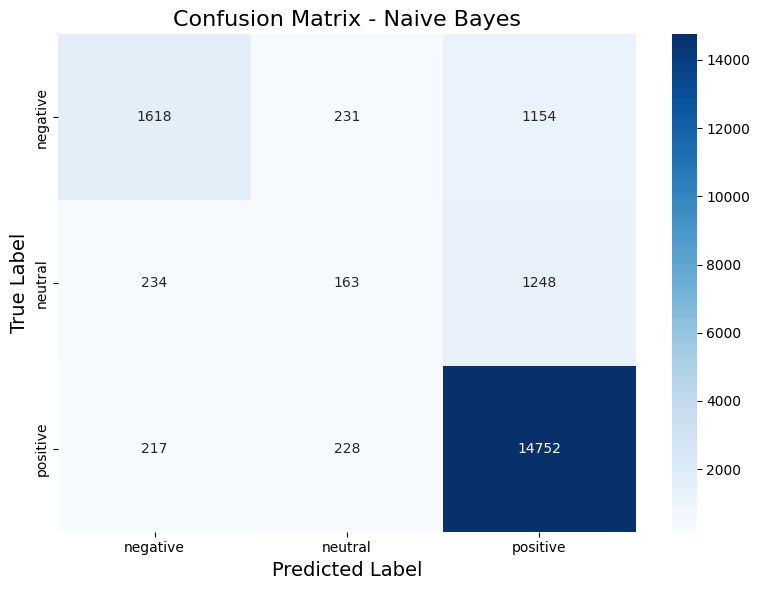

In [31]:
# Create and display confusion matrix

cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nb_classifier.classes_, 
            yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix - Naive Bayes', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()


## D - Building a More Advanced Model - Logistic Regression with TF-IDF

In [32]:
# Use TF-IDF Vectorizer for better feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Shape of training features (TF-IDF): {X_train_tfidf.shape}")
print(f"Shape of testing features (TF-IDF): {X_test_tfidf.shape}")



Shape of training features (TF-IDF): (79379, 5000)
Shape of testing features (TF-IDF): (19845, 5000)


In [33]:
# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

lr_classifier.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [34]:
# Make predictions on the test set
y_pred_lr = lr_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy: {accuracy_lr:.4f}")


Logistic Regression accuracy: 0.8455


In [35]:
# Display classification report

print("Classification Report:\n")
print(classification_report(y_test, y_pred_lr, target_names=lr_classifier.classes_))


Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.62      0.68      3003
     neutral       0.30      0.02      0.04      1645
    positive       0.86      0.98      0.92     15197

    accuracy                           0.85     19845
   macro avg       0.64      0.54      0.55     19845
weighted avg       0.80      0.85      0.81     19845



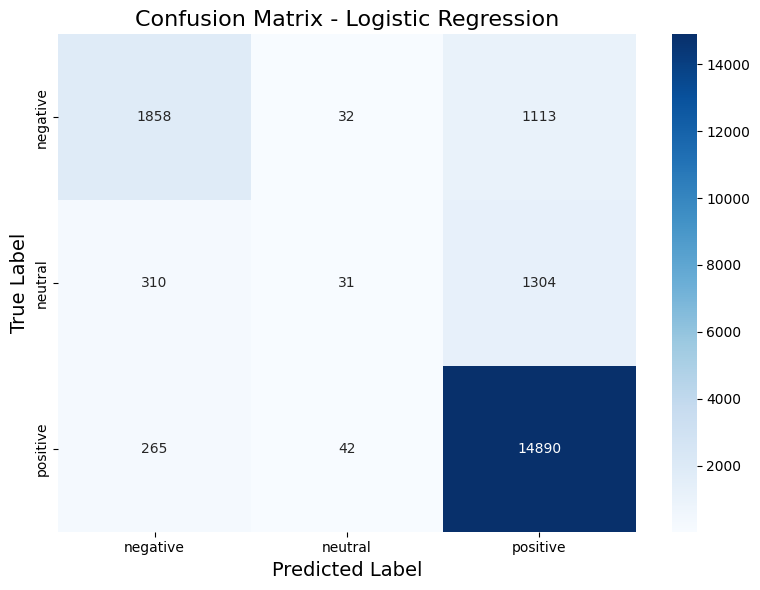

In [36]:
# Create and display confusion matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_classifier.classes_, 
            yticklabels=lr_classifier.classes_)
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show();


In [37]:
# Get feature importance from Logistic Regression model
feature_importance = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'importance': lr_classifier.coef_.mean(axis=0)
})

# Sort by absolute importance
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)


In [38]:
# Display most important positive and negative words
print("Top 10 words associated with positive sentiment:")
positive_features = feature_importance.sort_values('importance', ascending=False).head(10)
print(positive_features[['feature', 'importance']])

print("\nTop 10 words associated with negative sentiment:")
negative_features = feature_importance.sort_values('importance', ascending=True).head(10)
print(negative_features[['feature', 'importance']])


Top 10 words associated with positive sentiment:
         feature    importance
4492       ssimo  2.753353e-14
304   aguardando  1.465494e-14
751          bom  1.273056e-14
1999     explica  1.228647e-14
4203    resposta  1.206442e-14
1502       deram  1.199041e-14
3184         nao  1.154632e-14
4008       quero  1.132427e-14
1838    enviaram  1.102822e-14
3452     paraben  1.080617e-14

Top 10 words associated with negative sentiment:
       feature    importance
1324   contato -2.531308e-14
3891   produto -2.353673e-14
3617      pido -1.761554e-14
4525     super -1.125026e-14
1977  excelent -1.110223e-14
442        ant -1.095420e-14
1206   comprei -1.080617e-14
1815  entregam -1.043610e-14
1297   consigo -1.028807e-14
1945   estorno -1.014004e-14


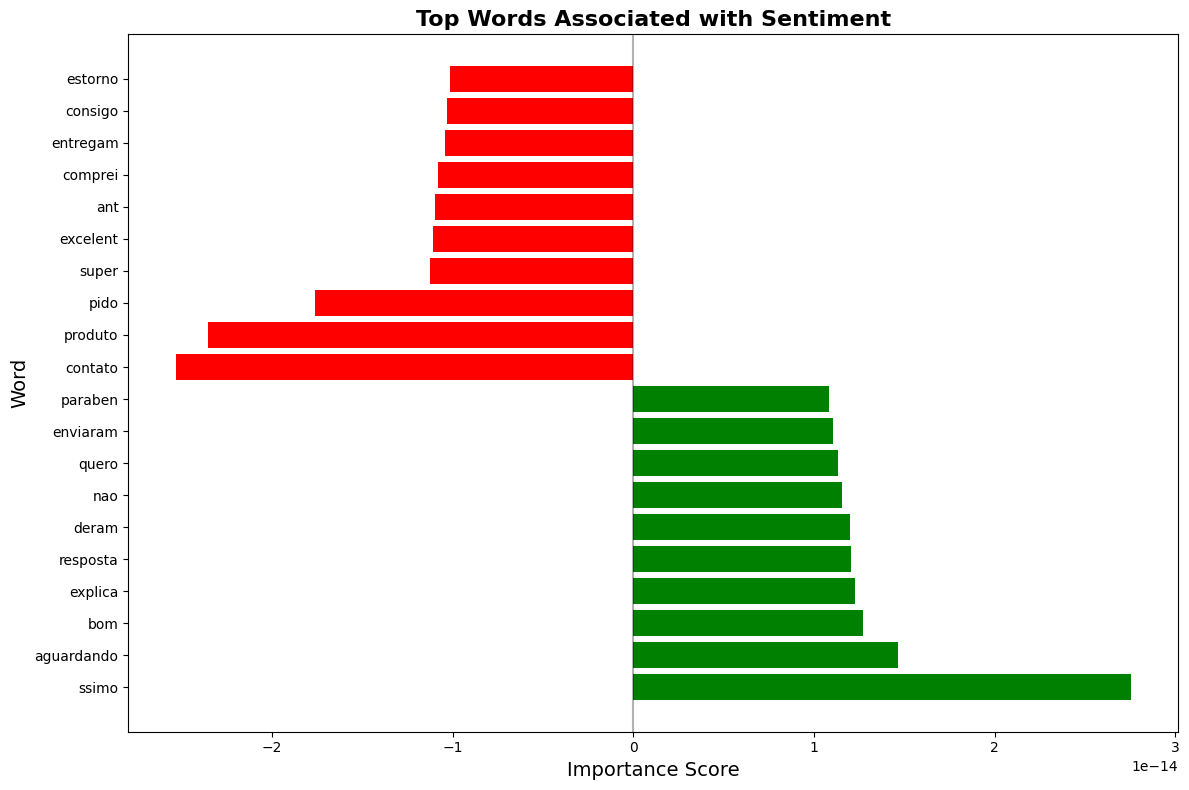

In [39]:
# Visualize top features
plt.figure(figsize=(12, 8))

top_features = pd.concat([positive_features.head(15), negative_features.head(15)])

colors = ['green' if x > 0 else 'red' for x in top_features['importance']]

# Create horizontal bar chart
plt.barh(top_features['feature'], top_features['importance'], color=colors)
plt.title('Top Words Associated with Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Word', fontsize=14)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show();


## E - Rainforest model

In [40]:
import time

In [41]:
# Start a timer to understand how long the model will last
start_time = time.time()

# Create a random forest model, while limiting the number of trees to make sure it doesn't run for too long
rf_classifier = RandomForestClassifier(
    n_estimators=100,     # number of trees in the forest
    max_depth=None,       # trees can be as deep (long) as possible
    min_samples_split=2,  # minimum split number to build a node (2 trees min to build a node)
    random_state=42,
    n_jobs=-1             # use all possible resources
)

# Use the model on the X_train TF-IDF data (same than the logistic regression)
rf_classifier.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Compute execution time
training_time = time.time() - start_time
print(f"Random Forest training: {training_time:.2f} seconds")


Random Forest training: 5.53 seconds


In [42]:
# Evaluate the model

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest accuracy: {accuracy_rf:.4f}")



Random Forest accuracy: 0.8430


In [43]:
# Display the classification report

print("Classification Report for Random Forest:\n")
print(classification_report(y_test, y_pred_rf, target_names=rf_classifier.classes_))


Classification Report for Random Forest:

              precision    recall  f1-score   support

    negative       0.73      0.63      0.68      3003
     neutral       0.29      0.01      0.02      1645
    positive       0.86      0.97      0.92     15197

    accuracy                           0.84     19845
   macro avg       0.63      0.54      0.54     19845
weighted avg       0.79      0.84      0.81     19845



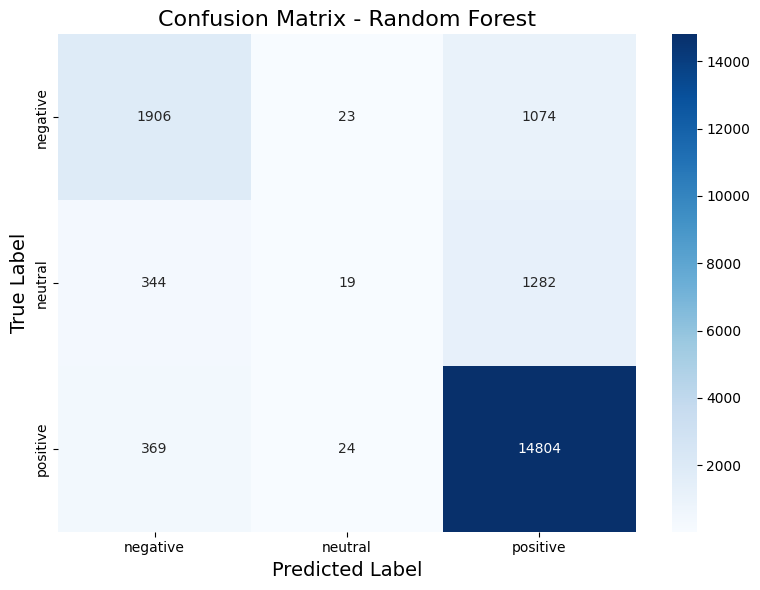

In [44]:
# Create and display the confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_classifier.classes_, 
            yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix - Random Forest', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()


In [45]:
# get the feature importance of the Random Forest model

importances = rf_classifier.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)


print("Top 20 words most important for Random Forest classification:")
print(rf_feature_importance.head(20))


Top 20 words most important for Random Forest classification:
         feature  importance
4075      recebi    0.038272
3891     produto    0.032238
1206     comprei    0.025684
316        ainda    0.019307
3184         nao    0.016283
3763       prazo    0.016140
4847        veio    0.015241
442          ant    0.013648
555           at    0.012503
304   aguardando    0.008998
1821     entregu    0.008541
3526      pedido    0.008445
4008       quero    0.008187
293        agora    0.007827
751          bom    0.007605
1811     entrega    0.007478
1025      chegou    0.007409
481        apena    0.007364
1604         dia    0.007265
4115   recomendo    0.007217


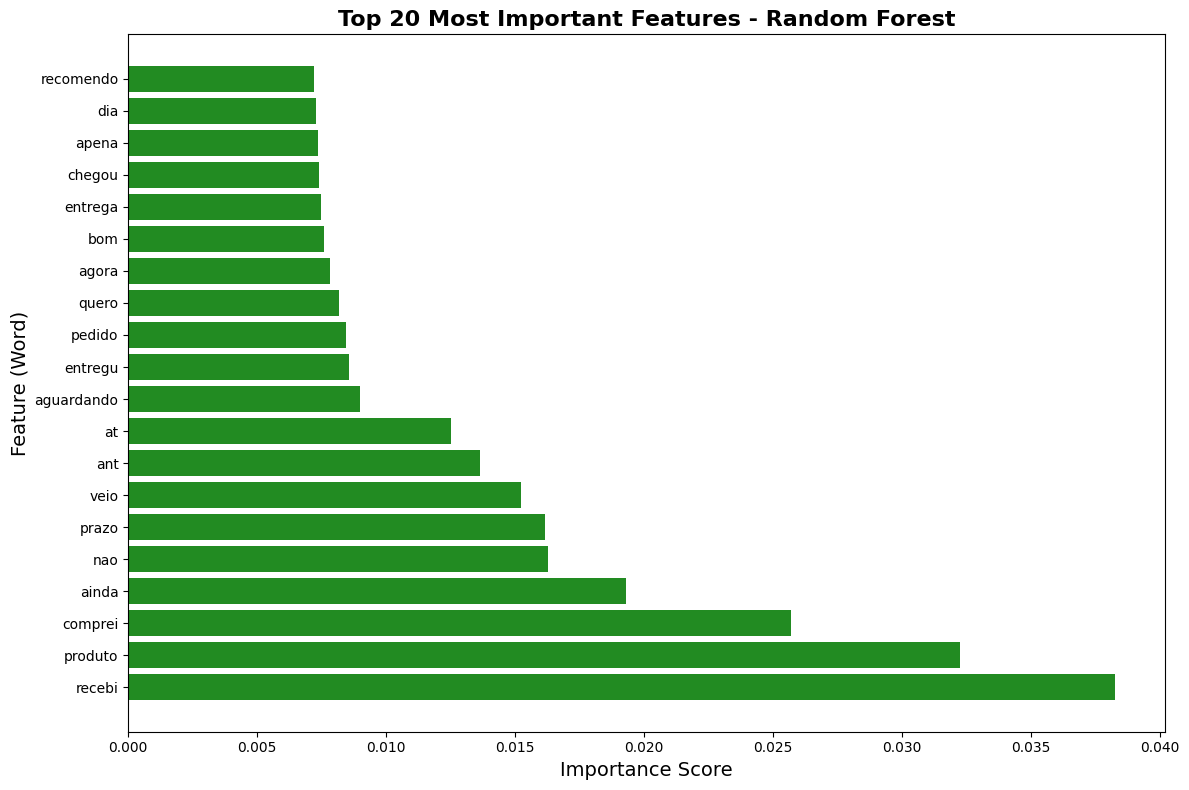

In [46]:
# Visualize the most important features

plt.figure(figsize=(12, 8))
plt.barh(rf_feature_importance['feature'][:20], rf_feature_importance['importance'][:20], color='forestgreen')
plt.title('Top 20 Most Important Features - Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature (Word)', fontsize=14)
plt.tight_layout()
plt.show()


## F - Model comparison

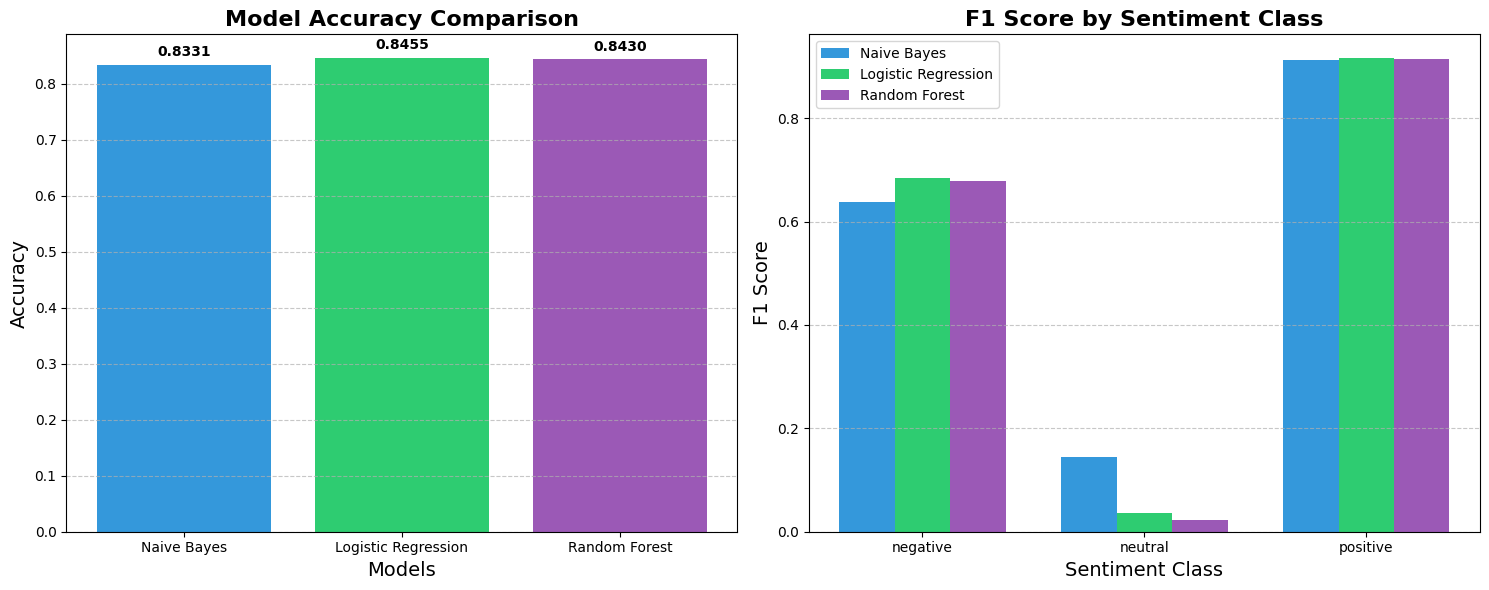

In [47]:
from sklearn.metrics import f1_score


# Compare the performances of the 2 models
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
accuracies = [accuracy_nb, accuracy_lr, accuracy_rf]

# Compute the F1 score for each class and model

f1_nb = f1_score(y_test, y_pred_nb, average=None)
f1_lr = f1_score(y_test, y_pred_lr, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the accuracy comparison
ax1.bar(models, accuracies, color=['#3498DB', '#2ECC71', '#9B59B6'])
ax1.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax1.set_xlabel('Models', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
# Add text labels above bars
for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot the F1 score comparison by class
x = np.arange(len(rf_classifier.classes_))
width = 0.25

ax2.bar(x - width, f1_nb, width, label='Naive Bayes', color='#3498DB')
ax2.bar(x, f1_lr, width, label='Logistic Regression', color='#2ECC71')
ax2.bar(x + width, f1_rf, width, label='Random Forest', color='#9B59B6')
ax2.set_title('F1 Score by Sentiment Class', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(rf_classifier.classes_)
ax2.set_xlabel('Sentiment Class', fontsize=14)
ax2.set_ylabel('F1 Score', fontsize=14)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## G - Example use case: predicting new comments

In [48]:
# Create a function to predict sentiment for new reviews
def predict_sentiment(review_text, vectorizer, model):
    # Preprocess the review
    processed_review = preprocess_text(review_text)
    # Vectorize the review
    review_vector = vectorizer.transform([processed_review])
    # Predict the sentiment
    sentiment = model.predict(review_vector)[0]
    # Get prediction probabilities
    proba = model.predict_proba(review_vector)[0]
    # Return the sentiment and confidence
    return sentiment, proba


In [49]:
# Example reviews to test
example_reviews = [
    "O produto é excelente, superou minhas expectativas!",  # Positive
    "Entrega foi feita no prazo, mas o produto não é tão bom quanto esperava.",  # Neutral
    "Péssimo produto, chegou com defeito e o atendimento ao cliente foi horrível."  # Negative
]

# Predict sentiment for example reviews
print("Predicting sentiment for example reviews:")
for i, review in enumerate(example_reviews):
    sentiment, proba = predict_sentiment(review, tfidf_vectorizer, lr_classifier)
    print(f"\nExample {i+1}: {review}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Confidence: {max(proba):.2f}")
    print(f"Probabilities: {dict(zip(lr_classifier.classes_, proba))}")


Predicting sentiment for example reviews:

Example 1: O produto é excelente, superou minhas expectativas!
Predicted sentiment: positive
Confidence: 1.00
Probabilities: {'negative': np.float64(0.0022869042615393667), 'neutral': np.float64(0.0026911537695488608), 'positive': np.float64(0.9950219419689118)}

Example 2: Entrega foi feita no prazo, mas o produto não é tão bom quanto esperava.
Predicted sentiment: positive
Confidence: 0.52
Probabilities: {'negative': np.float64(0.08752926262988439), 'neutral': np.float64(0.3972355691192068), 'positive': np.float64(0.5152351682509088)}

Example 3: Péssimo produto, chegou com defeito e o atendimento ao cliente foi horrível.
Predicted sentiment: negative
Confidence: 0.98
Probabilities: {'negative': np.float64(0.9792570188500327), 'neutral': np.float64(0.00641524295934131), 'positive': np.float64(0.014327738190625825)}


# II - Delivery prediction (bonus)

## A - Data preparation

In [50]:
# We'll use the merged dataframe from previous parts
# If not already done, we need to merge the necessary dataframes
if 'df' not in globals():
    # Load required datasets
    df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
    df_customers = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
    df_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
    df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
    
    # Merge datasets
    df = df_orders.merge(df_customers, on='customer_id')
    df = df.merge(df_order_items, on='order_id')
    df = df.merge(df_products, on='product_id')

df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0


In [51]:
# Convert date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])


# Calculate delivery time in days
df['actual_delivery_time'] = (df['order_delivered_customer_date'] - 
                             df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Calculate if the delivery was delayed (1) or not (0)
df['estimated_delivery_time'] = (df['order_estimated_delivery_date'] - 
                                df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)
df['is_delayed'] = (df['actual_delivery_time'] > df['estimated_delivery_time']).astype(int)

# Calculate time to carrier in days
df['time_to_carrier'] = (df['order_delivered_carrier_date'] - 
                        df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Filter out rows with missing delivery dates (canceled orders, etc.)
delivery_df = df.dropna(subset=['order_delivered_customer_date', 'order_delivered_carrier_date'])

delivery_df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,actual_delivery_time,estimated_delivery_time,is_delayed,time_to_carrier
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,8.436574,15.544063,0,2.373924
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,178.0,1.0,400.0,19.0,13.0,19.0,13.782037,19.137766,0,1.742627
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,232.0,1.0,420.0,24.0,19.0,21.0,9.394213,26.639711,0,0.216100
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,468.0,3.0,450.0,30.0,10.0,20.0,13.208750,26.188819,0,3.758252
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,316.0,4.0,250.0,51.0,15.0,15.0,2.873877,12.112049,0,0.936053


/var/folders/c8/v190j9n90gg6d6bhd7xsmm2r0000gn/T/ipykernel_29427/1813984735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_delayed', data=delivery_df, palette='viridis')


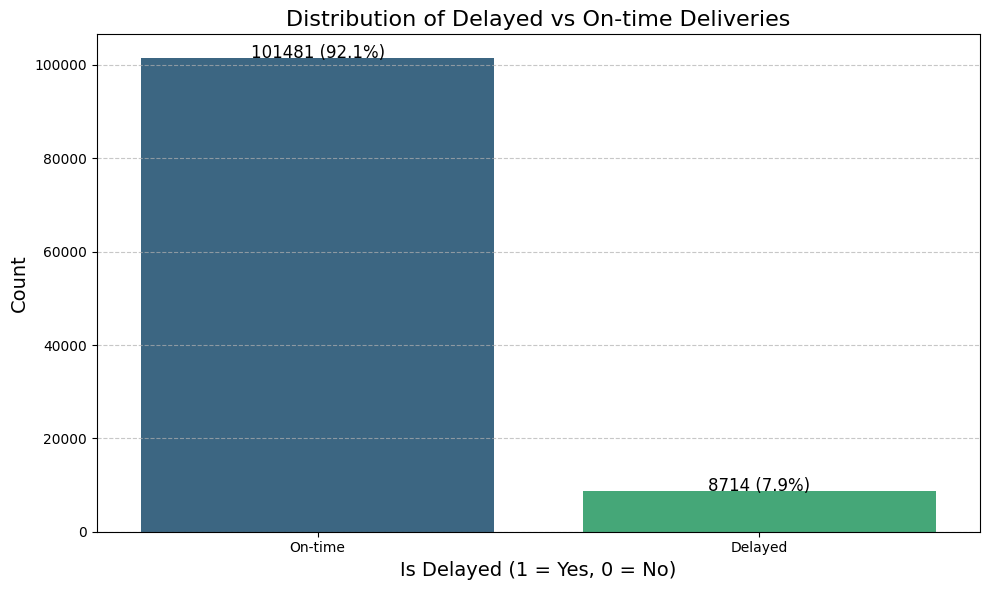

In [52]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='is_delayed', data=delivery_df, palette='viridis')
plt.title('Distribution of Delayed vs On-time Deliveries', fontsize=16)
plt.xlabel('Is Delayed (1 = Yes, 0 = No)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['On-time', 'Delayed'])
for i, count in enumerate(delivery_df['is_delayed'].value_counts()):
    plt.text(i, count + 100, f"{count} ({count/len(delivery_df):.1%})", 
             ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## B - Feature Engineering

In [53]:
model_df = delivery_df.copy()

# First, merge with seller data to get the seller zip code prefix
model_df = model_df.merge(df_sellers[['seller_id', 'seller_zip_code_prefix']], on='seller_id', how='left')

# Extract temporal features
model_df['purchase_hour'] = model_df['order_purchase_timestamp'].dt.hour
model_df['purchase_day'] = model_df['order_purchase_timestamp'].dt.day
model_df['purchase_month'] = model_df['order_purchase_timestamp'].dt.month
model_df['purchase_year'] = model_df['order_purchase_timestamp'].dt.year
model_df['purchase_dayofweek'] = model_df['order_purchase_timestamp'].dt.dayofweek
model_df['purchase_weekend'] = (model_df['purchase_dayofweek'] >= 5).astype(int)

# Calculate distance between customer and seller (using zip code prefix as a proxy)
model_df['zip_distance'] = abs(model_df['customer_zip_code_prefix'] - model_df['seller_zip_code_prefix'])

# Calculate price per weight
model_df['price_per_weight'] = model_df['price'] / model_df['product_weight_g'].replace(0, 0.1)

# Create product volume feature
model_df['product_volume'] = (model_df['product_length_cm'] * 
                             model_df['product_height_cm'] * 
                             model_df['product_width_cm'])

# Handle infinite values
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the first few rows of the engineered features
print("Sample of engineered features:")
model_df[['purchase_hour', 'purchase_day', 'purchase_month', 'purchase_year', 
                'purchase_dayofweek', 'purchase_weekend', 'zip_distance', 
                'price_per_weight', 'product_volume']].head()

Sample of engineered features:


,purchase_hour,purchase_day,purchase_month,purchase_year,purchase_dayofweek,purchase_weekend,zip_distance,price_per_weight,product_volume
0,10,2,10,2017,0,0,6201,0.059980,1976.0
1,20,24,7,2018,1,0,16243,0.296750,4693.0
2,8,8,8,2018,2,0,60425,0.380714,9576.0
3,19,18,11,2017,5,1,27454,0.100000,6000.0
4,21,13,2,2018,1,0,443,0.079600,11475.0


## C - Exploratory Data Analysis for Feature Selection

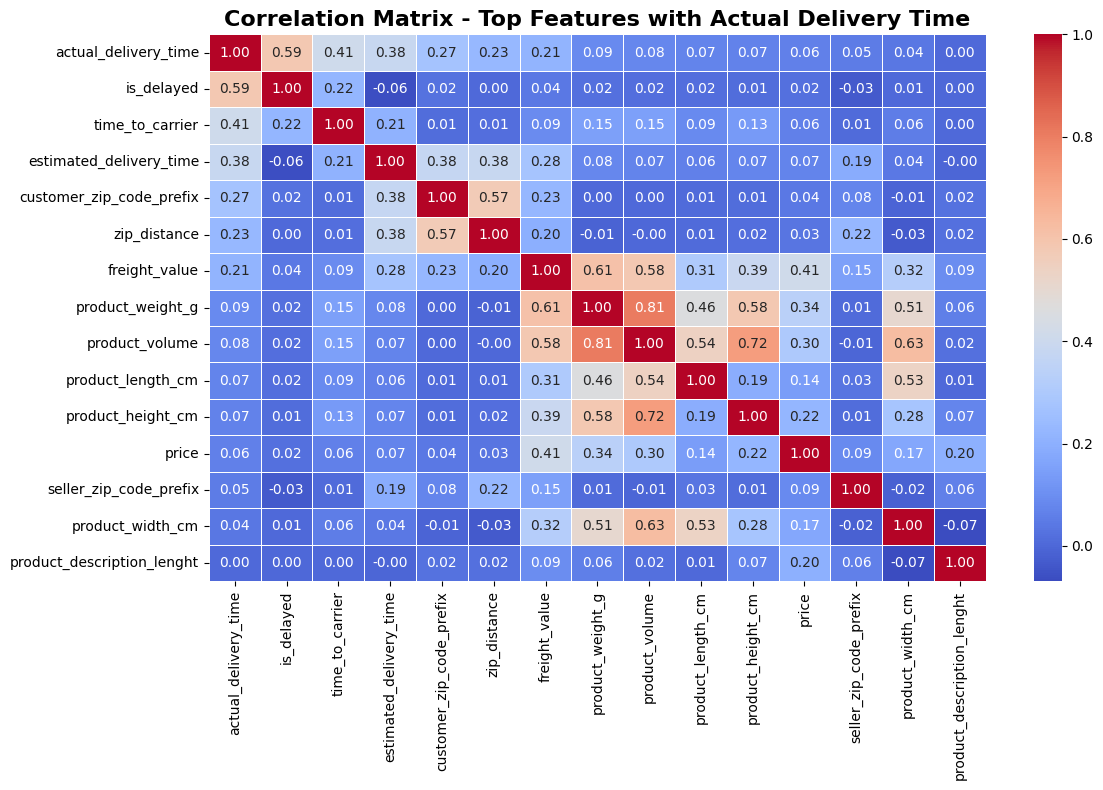

/var/folders/c8/v190j9n90gg6d6bhd7xsmm2r0000gn/T/ipykernel_29427/2634256690.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_delivery_abs.values, y=corr_with_delivery_abs.index, palette='viridis')


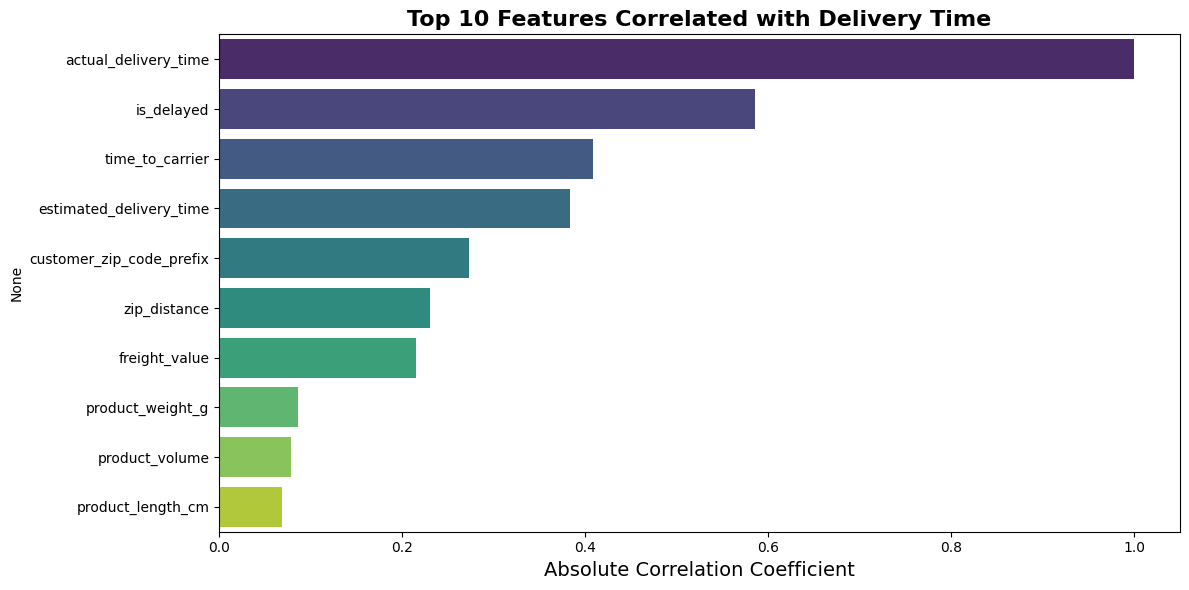

In [54]:
# Analyze correlation between features and delivery time with a correlation matrix

# Select numeric columns for correlation analysis
numeric_cols = model_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute the correlation matrix
corr_matrix = model_df[numeric_cols].corr()

# Plot the correlation with delivery time
plt.figure(figsize=(12, 8))
# Sort correlations by absolute value
corr_with_delivery = corr_matrix['actual_delivery_time'].sort_values(ascending=False)

# Create heatmap for top correlations with delivery time
top_corr_features = corr_with_delivery.index[:15]  # Top 15 features
top_corr_matrix = model_df[top_corr_features].corr()

# Create a heatmap for visual analysis
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - Top Features with Actual Delivery Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Create a bar chart showing correlation of top features with delivery time
plt.figure(figsize=(12, 6))
corr_with_delivery_abs = corr_with_delivery.abs().sort_values(ascending=False)[:10]  # Top 10 by absolute correlation
sns.barplot(x=corr_with_delivery_abs.values, y=corr_with_delivery_abs.index, palette='viridis')
plt.title('Top 10 Features Correlated with Delivery Time', fontsize=16, fontweight='bold')
plt.xlabel('Absolute Correlation Coefficient', fontsize=14)
plt.tight_layout()
plt.show()


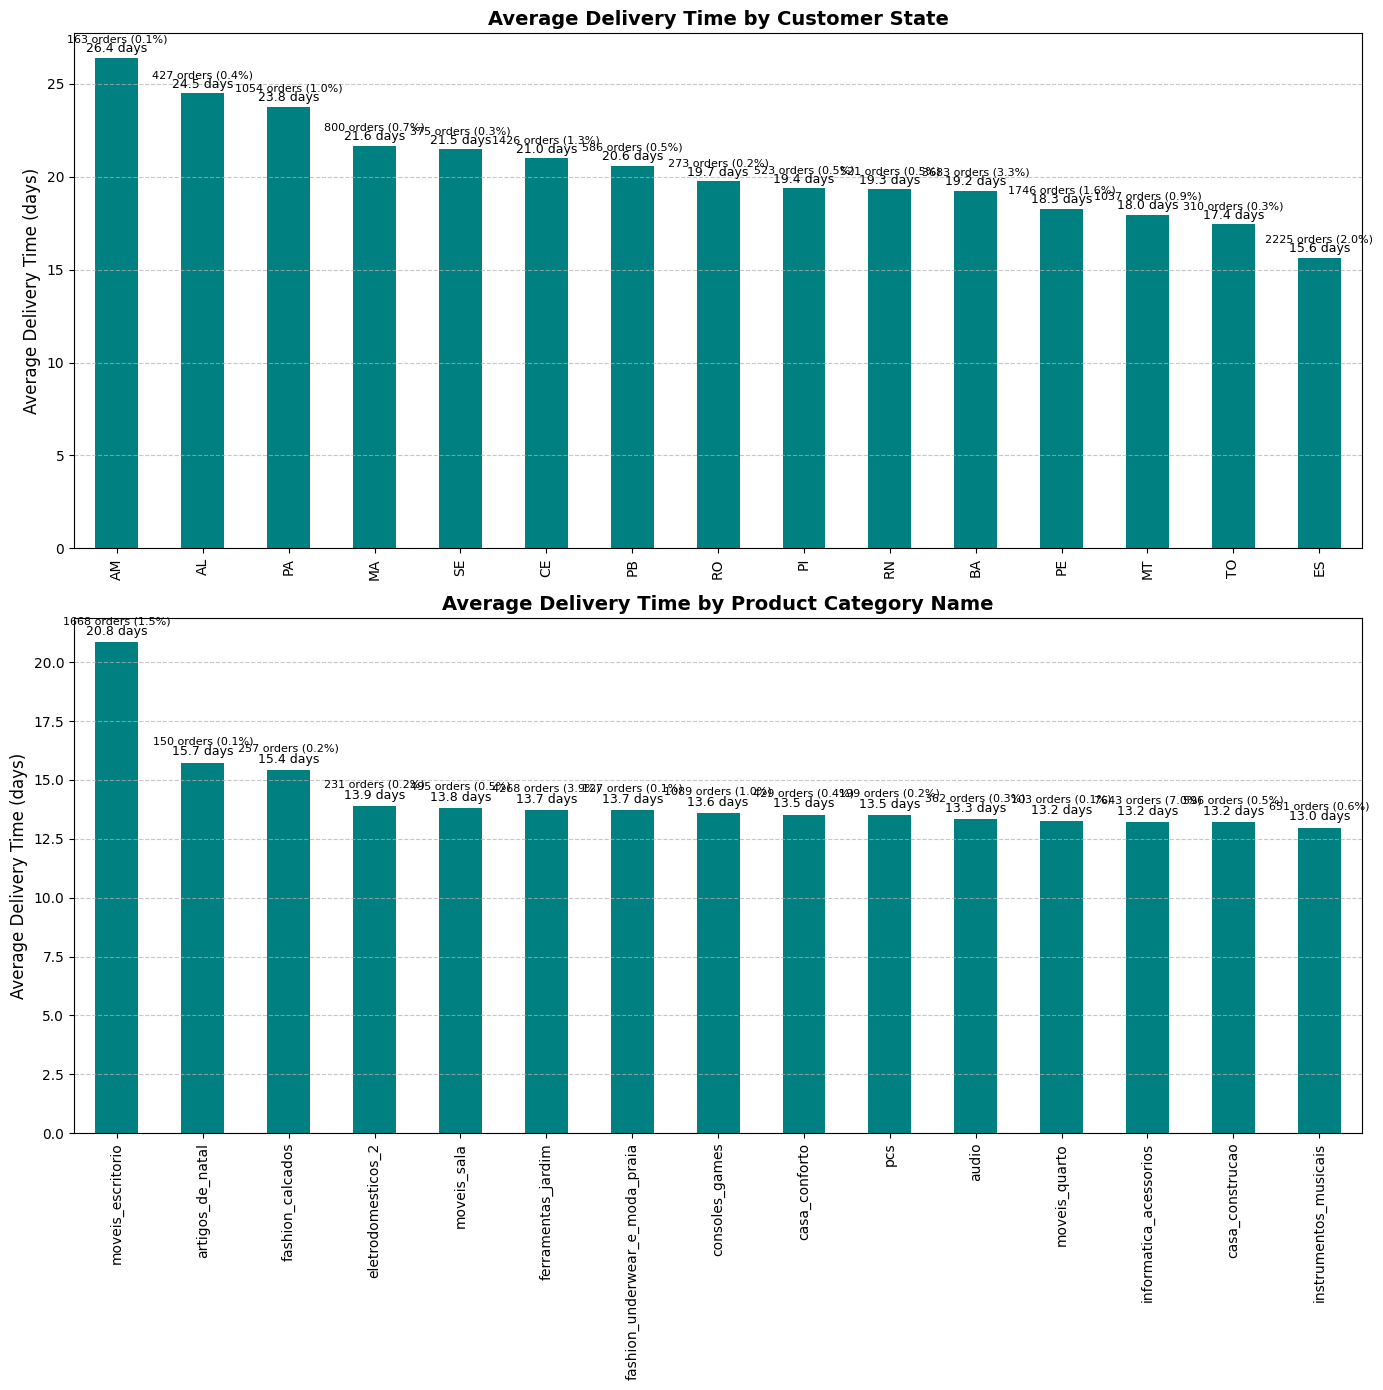

In [55]:
# Analyze categorical features
categorical_features = ['customer_state', 'product_category_name']

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Compute the average delivery time for each categorical feature
for i, feature in enumerate(categorical_features):
    # Create a temporary dataframe for analysis, dropping NaN values
    temp_df = model_df.dropna(subset=[feature, 'actual_delivery_time'])
    
    # Calculate mean delivery time for each category
    delivery_by_category = temp_df.groupby(feature)['actual_delivery_time'].mean().sort_values(ascending=False)
    
    # Filter to only include categories with enough data points (avoid outliers)
    category_counts = temp_df[feature].value_counts()
    significant_categories = category_counts[category_counts > 100].index
    
    # Filter the delivery times to only include significant categories
    delivery_by_category = delivery_by_category[delivery_by_category.index.isin(significant_categories)]
    
    # Take top 15 categories for better visualization
    delivery_by_category = delivery_by_category.head(15)
    
    # Plot the data
    bars = delivery_by_category.plot(kind='bar', ax=axes[i], color='teal')
    
    # Add value labels on top of bars
    for j, v in enumerate(delivery_by_category):
        axes[i].text(j, v + 0.3, f"{v:.1f} days", ha='center', fontsize=9)
    
    # Set titles and labels
    axes[i].set_title(f'Average Delivery Time by {feature.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Average Delivery Time (days)', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count information in the legend
    for j, cat in enumerate(delivery_by_category.index):
        count = category_counts[cat]
        percentage = count / len(temp_df) * 100
        axes[i].annotate(f"{count} orders ({percentage:.1f}%)", 
                        xy=(j, delivery_by_category[cat]), 
                        xytext=(j, delivery_by_category[cat] + 0.7),
                        ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Now create categorical feature encoding selection
selected_categorical_features = ['customer_state', 'seller_state', 'product_category_name']


## D - Feature Selection

In [56]:
# Select features based on correlation analysis and domain knowledge
selected_numeric_features = ['freight_value', 'price', 'product_weight_g', 
                            'product_volume', 'zip_distance', 'time_to_carrier',
                            'purchase_month', 'purchase_dayofweek']


In [57]:
# Prepare feature and target variables
X_numeric = model_df[selected_numeric_features]

# Fix the categorical features - remove seller_state as it's not in the dataframe
# We can check if it exists first
if 'seller_state' in model_df.columns:
    X_categorical = model_df[selected_categorical_features]
else:
    # Remove seller_state from the list
    available_cat_features = [col for col in selected_categorical_features if col != 'seller_state']
    X_categorical = model_df[available_cat_features]

X_combined = pd.concat([X_numeric, X_categorical], axis=1)

# For regression task (predicting delivery time)
y_regression = model_df['actual_delivery_time']

# Split the data
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_combined, y_regression, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Features used: {X_combined.columns.tolist()}")

Training set shape: (88156, 10)
Testing set shape: (22039, 10)
Features used: ['freight_value', 'price', 'product_weight_g', 'product_volume', 'zip_distance', 'time_to_carrier', 'purchase_month', 'purchase_dayofweek', 'customer_state', 'product_category_name']


## E - Building the Regression Model (Predicting Delivery Time)

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define preprocessing for numeric features

# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selected_numeric_features),
        ('cat', categorical_transformer, [col for col in selected_categorical_features if col in X_combined.columns])
    ])

# Print the features that will be processed
print(f"Numeric features: {selected_numeric_features}")
print(f"Categorical features: {[col for col in selected_categorical_features if col in X_combined.columns]}")


Numeric features: ['freight_value', 'price', 'product_weight_g', 'product_volume', 'zip_distance', 'time_to_carrier', 'purchase_month', 'purchase_dayofweek']
Categorical features: ['customer_state', 'product_category_name']


In [59]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Create a Linear Regression Pipeline

'your code here'

# Train and evaluate Linear Regression

# Create a Linear Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
lr_pipeline.fit(X_train, y_reg_train)

# Make predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_reg_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_reg_test, y_pred_lr))
r2_lr = r2_score(y_reg_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr:.2f} days")
print(f"Linear Regression - RMSE: {rmse_lr:.2f} days")
print(f"Linear Regression - R²: {r2_lr:.2f}")


Linear Regression - MAE: 4.55 days
Linear Regression - RMSE: 7.32 days
Linear Regression - R²: 0.37


Linear Regression - MAE: 4.55 days
Linear Regression - RMSE: 7.32 days
Linear Regression - R²: 0.37


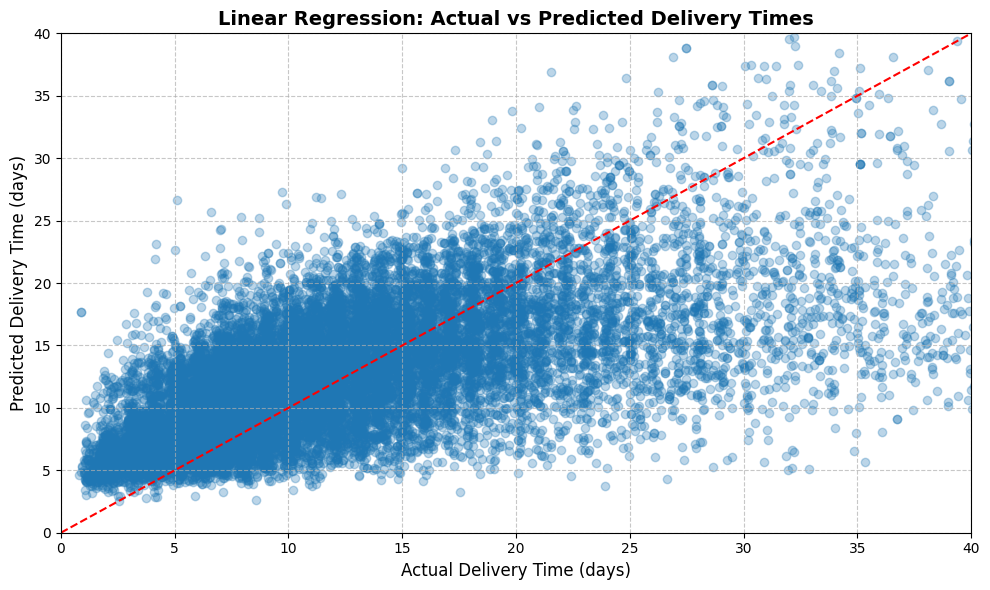

In [60]:
# Make predictions based on your linear regression model
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_reg_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_reg_test, y_pred_lr))
r2_lr = r2_score(y_reg_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr:.2f} days")
print(f"Linear Regression - RMSE: {rmse_lr:.2f} days")
print(f"Linear Regression - R²: {r2_lr:.2f}")

# Create a scatter plot to visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_pred_lr, alpha=0.3)
plt.plot([0, 40], [0, 40], 'r--')  # Diagonal line for perfect predictions
plt.xlabel('Actual Delivery Time (days)', fontsize=12)
plt.ylabel('Predicted Delivery Time (days)', fontsize=12)
plt.title('Linear Regression: Actual vs Predicted Delivery Times', fontsize=14, fontweight='bold')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


the R² should be about 0.40, which is not a good number. Can you do better with a Random Forest model, or any other model? 

Objective is to get a R² > 0.45!

## F - Building a Random Forest model

Training Random Forest model...
Training took 23.41 seconds

Random Forest Model Metrics:
Mean Absolute Error: 4.0074
Root Mean Squared Error: 6.7862
R² Score: 0.4576
Improvement over Linear Regression: 8.89%


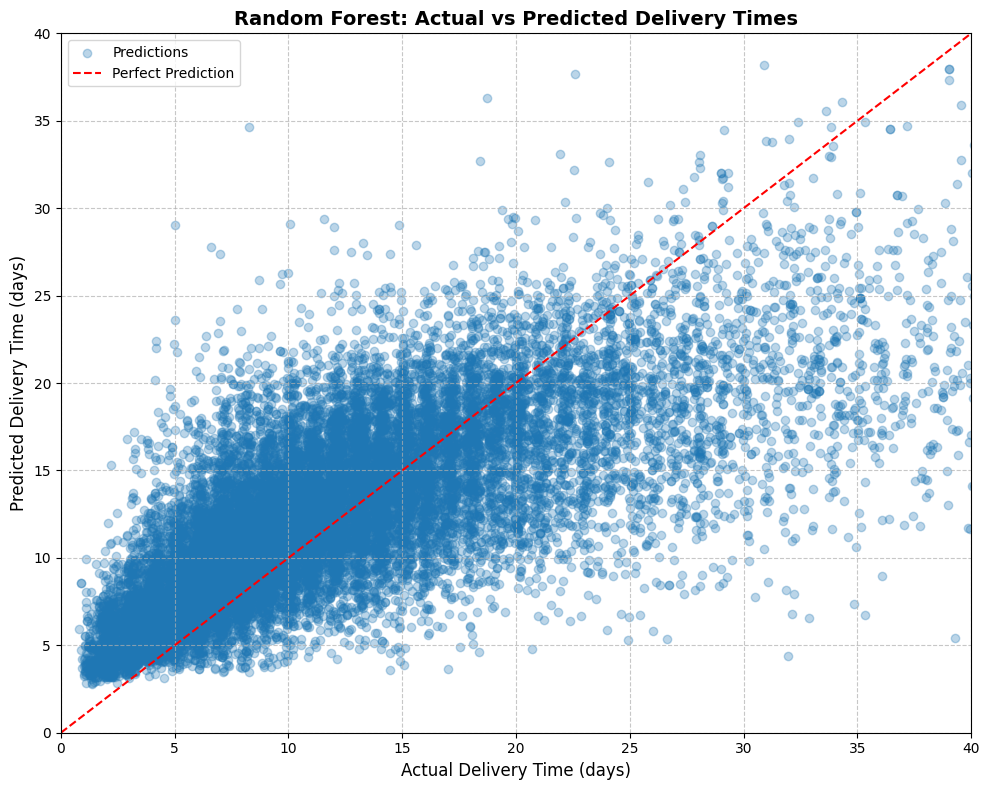

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

start_time = time.time()

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=300,            
        max_depth=25,                 
        min_samples_split=4,          
        min_samples_leaf=1,           
        max_features='sqrt',          
        bootstrap=True,               
        n_jobs=-1,                    
        random_state=42
    ))
])

print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_reg_train)

y_pred_rf = rf_pipeline.predict(X_test)

mae_rf = mean_absolute_error(y_reg_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_reg_test, y_pred_rf))
r2_rf = r2_score(y_reg_test, y_pred_rf)

training_time = time.time() - start_time
print(f"Training took {training_time:.2f} seconds")

print("\nRandom Forest Model Metrics:")
print(f"Mean Absolute Error: {mae_rf:.4f}")
print(f"Root Mean Squared Error: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")
print(f"Improvement over Linear Regression: {(r2_rf-r2_lr)*100:.2f}%")

plt.figure(figsize=(10, 8))
plt.scatter(y_reg_test, y_pred_rf, alpha=0.3, label='Predictions')
plt.plot([0, 40], [0, 40], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Delivery Time (days)', fontsize=12)
plt.ylabel('Predicted Delivery Time (days)', fontsize=12)
plt.title('Random Forest: Actual vs Predicted Delivery Times', fontsize=14, fontweight='bold')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### G - Building a K-Nearest Neighbors model

Training KNN model...
Training took 49.47 seconds

K-Nearest Neighbors Model Metrics:
Mean Absolute Error: 3.9159
Root Mean Squared Error: 7.0832
R² Score: 0.4091
Improvement over Linear Regression: 4.04%
Improvement over Random Forest: -4.85%


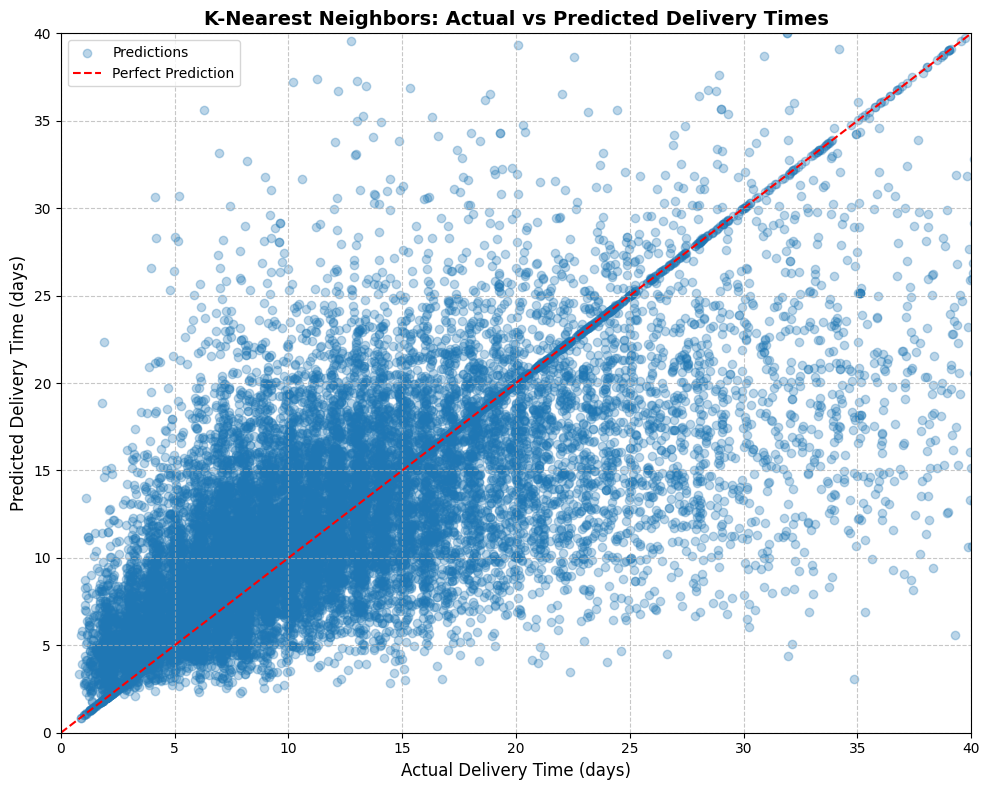

In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# Start a timer to track training time
start_time = time.time()

# Create a KNN Pipeline with preprocessing
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_neighbors=10,   # Number of neighbors to consider
        weights='distance',  # Weight points by inverse of their distance
        algorithm='auto',    # Automatically choose the best algorithm
        leaf_size=30,        # Leaf size for tree algorithms
        p=2,                 # Power parameter for Minkowski metric (2 = Euclidean)
        n_jobs=-1            # Use all available cores
    ))
])

# Train the model
print("Training KNN model...")
knn_pipeline.fit(X_train, y_reg_train)

# Make predictions
y_pred_knn = knn_pipeline.predict(X_test)

# Calculate metrics
mae_knn = mean_absolute_error(y_reg_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_reg_test, y_pred_knn))
r2_knn = r2_score(y_reg_test, y_pred_knn)

# Calculate training time
training_time = time.time() - start_time
print(f"Training took {training_time:.2f} seconds")

# Print results
print("\nK-Nearest Neighbors Model Metrics:")
print(f"Mean Absolute Error: {mae_knn:.4f}")
print(f"Root Mean Squared Error: {rmse_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")
print(f"Improvement over Linear Regression: {(r2_knn-r2_lr)*100:.2f}%")
print(f"Improvement over Random Forest: {(r2_knn-r2_rf)*100:.2f}%")

# Visualize results
plt.figure(figsize=(10, 8))
plt.scatter(y_reg_test, y_pred_knn, alpha=0.3, label='Predictions')
plt.plot([0, 40], [0, 40], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Delivery Time (days)', fontsize=12)
plt.ylabel('Predicted Delivery Time (days)', fontsize=12)
plt.title('K-Nearest Neighbors: Actual vs Predicted Delivery Times', fontsize=14, fontweight='bold')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()